In [2]:
import gym
import gym_battleship_basic
import numpy as np
import pandas as pd
from tqdm import tqdm 
import matplotlib.pyplot as plt
import os
import pickle
import numpy as np
# from tensorflow.keras import backend
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
import gym
import random
import os
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from keras.models import load_model
%matplotlib inline
from IPython.display import HTML
import numpy as np
import gym
from matplotlib import colors
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam
import time
from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.policy import GreedyQPolicy
from keras.layers import Flatten, Convolution2D, Input
import copy
# 1.1 Import tensorflow and other libraries.
import tensorflow as tf
import numpy as np
%matplotlib inline
import pylab
import gc
import os

In [37]:
# os.path.join(os.getcwd(),".\..")
root_path = os.getcwd() # please specific the root path to load pacakages.
if os.getcwd().split("\\")[-1] == 'notebooks':
    root_path = os.path.dirname(os.getcwd())
    os.chdir(root_path)
    print(root_path)
# else:

import sys
if filename not in sys.path:
    sys.path.append(root_path)

from agents.CNN_Agent import CNN_Agent
from agents.DoubleModel_DQN import DoubleModel_DQN
from agents.HuntTarget_Agent import HuntTargetAgent
from agents.SingleModel_DQN import DQN_Agent
from agents.MC_Agent import MCAgent
from agents.MCTS_Agent import MCTS_Battleship
from agents.util import train_data_process, agent_test, single_frame_viz
from agents.util import game_viz

In [74]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [3]:
# def agent_test(agent, env, game_rounds, agent_name='battleship', model_agent=False, log_save=False):
#     step_record = []
#     reward_record = []
#     data_dict ={}
#     for i in tqdm(range(game_rounds)):
#         if agent.log_saving:
#             agent.reset_log()
#         total_step, reward = agent.test(env)
#         step_record += [total_step]
#         reward_record += [reward]
#         if log_save:
#             data_dict[i] ={'observations': agent.obs_hist, 
#                            'target': env.board.map.flatten(), 
#                            'shot':agent.shot_log}
#             if model_agent:
#                 data_dict[i]['shot']=agent.shot_log
#                 data_dict[i]['model_estimates']=agent.model_estimates
                
            
#     result_df = pd.DataFrame({'AgentName':[agent_name]*len(step_record),
#                                        'steps':step_record,
#                                        'reward':reward_record})
#     return result_df, data_dict

## Game Intro & Environment Setup

The battleship is a very classic board game with very intuitive rules. This is a 2 players game. For each player, s/he have a 10*10 board to place the fleet and then claim shots on the other players boards. The goal is simply to sink all your opponent's ship.


For example, with the classic rules, there are five ships on board as follows:

![Battleship Board](images\board.png)

Typically, these five ships above are:
* Aircraft Carrier (Size 5)
* Battleship (Size 4)
* Submarine (Size 3)
* Cruiser (Size 3)
* Destroyer	 (Size 2)


Thoughthis is a two players game, Clearly, we could convert this problem to finish the game with smallest number of shot. As long as you could finish the game fast, you will have higher chance to win the game. 

In [2]:
env = gym.make('battleshipBasic-v0',board_shape=(10,10), verbose=False)
obs = env.step(20)
obs = env.step(45)
obs = env.step(47)

Regarding my program, I set up my game with Open AI API. My environment will take shot as the input of each step and return observations in 2D or 3D.

__Sample Observation 2D__

In this type of observation return, 0 means unexplored cells, 1 means miss and 2 means hit. In the sample result below, we have placed 3 shots and 1 of 3 hit the target.


In [57]:

obs = env.step(34)
print(obs[0])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 2. 0. 0. 0. 0. 0.]
 [1. 2. 2. 2. 2. 2. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


### Simulation board setting

__Sample Observation 3D__

In this type of observation return, there are 3 matrcies that represents explored, misses and hits. 

In [7]:
env = gym.make('battleshipBasic-v0',board_shape=(10,10), verbose=False, obs_3d=True)
obs = env.step(20)
obs = env.step(45)
obs = env.step(47)

__Explored or Not Matrix__: In this observation, we have placed 3 shots already.

In [8]:
print(obs[0][...,0])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


__Miss or Not Matrix__: In this observation, 2 of our shots misses the target

In [9]:
print(obs[0][...,1])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


__Hit or Not Matrix__: In this observation, 1 of our shots hits the target

In [10]:
print(obs[0][...,2])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


## Random Agent

This type of agent will keep placing random shots till game ends. This agent takes ~96 steps to finish a game on average

In [5]:
class RandomAgent(object):
    def __init__(self, verbose=False, log_saving= False):
        self.verbose = verbose
        self.log_saving= log_saving
        self.obs_hist= None
        self.shot_log = []
        
    def action(self, obs):
        i,j = np.nonzero(np.nan_to_num(obs / obs)-1)
        idx = np.random.choice(len(i), 1, replace=False)     
        if self.verbose:
            print('remaining space', len(i))
        return i[idx[0]], j[idx[0]]
    

    def reset_log(self):
        self.obs_hist = None
        self.shot_log = []
        
    def test(self, env):
        obs, done, ep_reward = env.reset(), False, 0
        i = 0 
        while not done:
            i +=1
            y, x = self.action(obs)
            action = y*env.shape[0]+x
#             print('current shot {} with original y {} x {}'.format(action, y, x))
            obs, reward, done,_ = env.step(action)
            if self.log_saving:
                if i == 1:
                    self.obs_hist = obs.flatten()
                    self.shot_log  = [action]
                else:
                    self.obs_hist = np.vstack([self.obs_hist, obs.flatten()])
                    self.shot_log  += [action]
            ep_reward += reward
        return i, ep_reward           
            

In [7]:
env = gym.make('battleshipBasic-v0',board_shape=(10,10), verbose=False)
RandomAgent1 = RandomAgent(verbose=False, log_saving=True)
RandomAgent_GameRecord,_ =\
    agent_test(agent=RandomAgent1, 
               env=env, 
               game_rounds=500, 
               agent_name='RandomAgent', 
               model_agent=False, 
               log_save=False)

RandomAgent_GameRecord.to_csv(r'c:\temp\RandomAgentResult.csv')

  0%|                                                                                                                                                                                                                                                                                         | 0/500 [00:00<?, ?it/s]C:\Users\Muxi\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 112.10it/s]


In [62]:
1/112.10

0.008920606601248885

In [8]:
print('average steps uses is {}'.format(RandomAgent_GameRecord['steps'].mean()))

average steps uses is 95.472


In [87]:
env = gym.make('battleshipBasic-v0',board_shape=(10,10), verbose=False)
RanddomAgent1 = RandomAgent(verbose=False, log_saving=True)
_, RandomAgent_game_log =\
    agent_test(agent=RanddomAgent1, 
               env=env, 
               game_rounds=10, 
               agent_name='RandomAgent', 
               model_agent=False, 
               log_save=True)

In [63]:
random_agent_game = game_viz(board_shape=(10,10),agent_name='RandomAgent', 
                           game_hist=RandomAgent_game_log[1],
                           anim_flag=True,
                           obs_3d=False,
                            label_c='white')

![SegmentLocal](images\RandomAgent_Game.gif "segment")

## Hunt & Target Agent

This type of agent will do following:

* Place random shot as search
* Once hit, the explore all nearby cells. If exhuast all nearby cells, back to step 1.

This type of agent takes aroudn 66 steps on average to finish a game.


In [45]:
class HuntTargetAgent(object):
    def __init__(self, board_shape, verbose=False, log_saving= False):
        self.verbose = verbose
        self.shape = board_shape
        self.log_saving= log_saving
        self.obs_hist= None
        self.strategy_mode = 'S' # initialize to S as 
        self.hunt_queue = []
        self.shot_log = []
        self.prev_obs = np.zeros([self.shape[0], self.shape[1]], dtype=np.int16)
        self.neighbour_moves = [(-1,0),(1,0),(0,1),(0,-1)]
        
    def reset_log(self):
        self.shot_log = []
        self.obs_hist= None        
        
        
    def add_hunt_queue(self, obs):
#         print(obs.shape, self.prev_obs.shape)
        hit_info = obs - self.prev_obs
        # if the new hit cell has value >1, we've got a hit
        
        hit_cell = np.where(hit_info>1)
        hit_cell = list(zip(hit_cell[0],hit_cell[1]))
        if len(hit_cell) ==1:
            if self.verbose:
                print('there is hit start add hunt list')
            hit_cell = hit_cell[0]
            for move in self.neighbour_moves:
                new_cell = (hit_cell[0] + move[0], hit_cell[1] + move[1])
                if (new_cell[0] <self.shape[0]) and (new_cell[1] <self.shape[0]) and  (new_cell[0] >=0)\
                and (new_cell[1] >=0) and (obs[new_cell[0]][new_cell[1]] == 0) and  (new_cell not in self.hunt_queue):
                    self.hunt_queue.append(new_cell)
            if self.verbose:
                print('current queue is {}'.format(self.hunt_queue))
                
    def action(self, obs):
        if len(obs.shape) == 3:
            obs = obs[...,0] + obs[...,2] # flatten the inputs            
        self.add_hunt_queue(obs)
        if len(self.hunt_queue) > 0:
            self.strategy_mode = 'H'
            next_move = self.hunt_queue[0]
            self.hunt_queue = self.hunt_queue[1:] 
            return  next_move[0], next_move[1]
        else:
            self.startegy_mode = 'S'
            i,j = np.nonzero(np.nan_to_num(obs / obs)-1)
            idx = np.random.choice(len(i), 1, replace=False)     
            if self.verbose:
                print('remaining space', len(i))
#             self.pre_obs = obs # update hist            
            return i[idx[0]], j[idx[0]]
    
    def test(self, env):
        obs, done, ep_reward = env.reset(), False, 0
        i = 0 
        while not done:
            i +=1
            y, x = self.action(obs)
            if len(obs.shape) == 3:
                obs = obs[...,0] + obs[...,2] # flatten the inputs 
            self.prev_obs = obs
            action = y*env.shape[0]+x            
            obs, reward, done,_ = env.step(action)            
            if self.log_saving:
                if i == 1:
                    self.obs_hist = obs.reshape((1,)+obs.shape)
                    self.shot_log = [action]
                else:
#                     print(self.obs_hist.shape,obs.reshape((1,)+obs.shape).shape )
                    self.obs_hist = np.concatenate([self.obs_hist, obs.reshape((1,)+obs.shape)])
                    self.shot_log += [action]
            ep_reward += reward
        return i, ep_reward    

    def reset_log(self):
        self.obs_hist = None
        self.shot_log = []
            
            
            

In [55]:
env = gym.make('battleshipBasic-v0',board_shape=(10,10), verbose=False, obs_3d=True)
HuntTargetAgent1 = HuntTargetAgent(board_shape=(10,10), verbose=False, log_saving=True)
HuntTargetAgent_GameRecord,SearchHunt_GameDict =\
    agent_test(agent=HuntTargetAgent1, 
               env=env, 
               game_rounds=10, 
               agent_name='SearchHuntAgent', 
               model_agent=False, 
               log_save=True)
print(SearchHunt_GameDict[0]['observations'].shape)
# with open(r'.\..\data\huntSearch_agentGames.pickle', 'wb') as handle:
#     pickle.dump(SearchHunt_GameDict, handle, protocol=pickle.HIGHEST_PROTOCOL)
# HuntTargetAgent_GameRecord.to_csv(r'c:\temp\HuntTargetAgentResult.csv')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 153.79it/s]

(52, 10, 10, 3)


In [63]:
1/153.79

0.006502373366278692

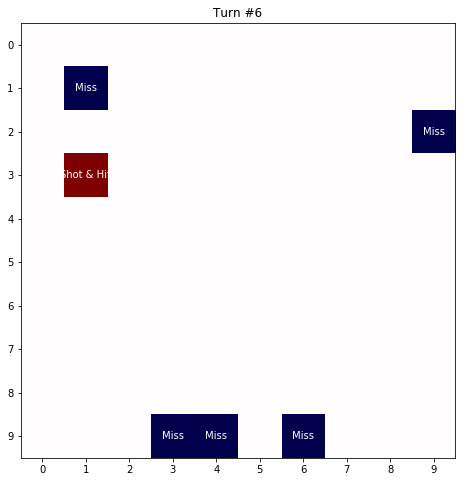

In [56]:
SModel_framer = single_frame_viz(5,game_hist=SearchHunt_GameDict[2],  
                                 model_obj=None, 
                                 obs_3d=True,                         
                                 model_agent=False,
                                 board_shape=(10,10), 
                                 value_range=(-1,1),title='Turn #6',
                                 label_c='white' )


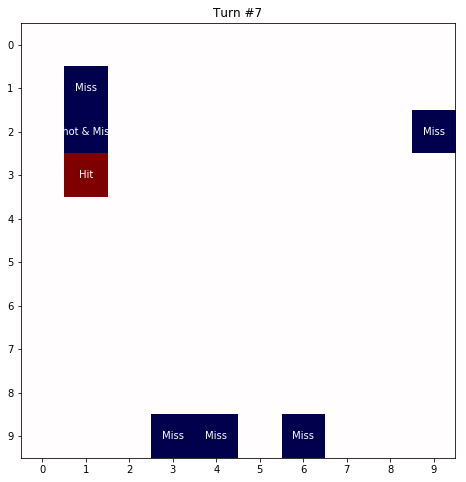

In [61]:
SModel_framer = single_frame_viz(6,game_hist=SearchHunt_GameDict[2],  
                                 model_obj=None, 
                                 obs_3d=True,                         
                                 model_agent=False,
                                 board_shape=(10,10), 
                                 value_range=(-1,1),title='Turn #7',
                                 label_c='white' )


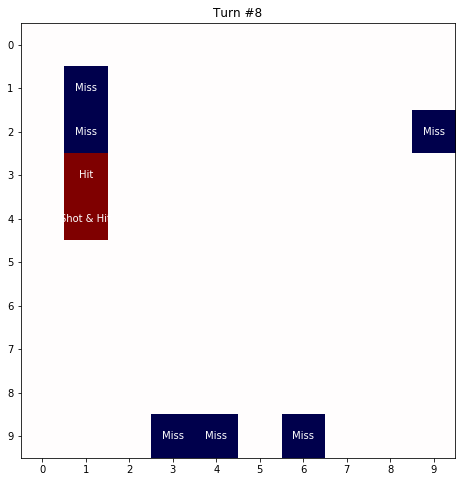

In [59]:
SModel_framer = single_frame_viz(7,game_hist=SearchHunt_GameDict[2],  
                                 model_obj=None, 
                                 obs_3d=True,                         
                                 model_agent=False,
                                 board_shape=(10,10), 
                                 value_range=(-1,1),title='Turn #8',
                                 label_c='white' )


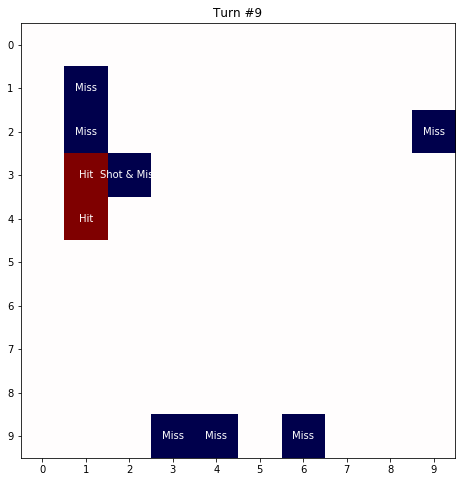

In [62]:
SModel_framer = single_frame_viz(8,game_hist=SearchHunt_GameDict[2],  
                                 model_obj=None, 
                                 obs_3d=True,                         
                                 model_agent=False,
                                 board_shape=(10,10), 
                                 value_range=(-1,1),title='Turn #9',
                                 label_c='white' )


In [11]:
# SearchHunt_GameRecord.to_csv(r'c:\temp\searchtarget_result.csv')
print('average steps uses is {}'.format(HuntTargetAgent_GameRecord['steps'].mean()))

average steps uses is 66.328


In [88]:
# SearchHunt_game = game_viz(board_shape=(10,10),agent_name='hunt_target_agent', 
#                            game_hist=SearchHunt_GameDict[1],
#                            anim_flag=True,                           
#                            obs_3d=True,
#                             label_c='white' )

![SegmentLocal](images\hunt_target_agent_Game2.gif "segment")

## CNN Agent

Another methodology to estimate the probability that there is a ship in a specific cell. Following picture shows the main ideas of this methodology.

![Probability Density Function](images\probDensityFunc.png)

There are many ways to calculate the probability. What I implented is to use a CNN model to predict this.


__Input__: the 3D observation from the environment

__target__:


| 0|1 |2|3|4|5|6|
| --- | --- | --- | --- | --- | --- | --- |
| 1 | 0 | 0 | 0 | 0 |0 | 0 |
| 1 | 0 | 2 | 0 | 0 |3 | 0 |
| 1 | 0 | 2 | 0 | 0 |3 | 0 |
| 1 | 0 | 2 | 0 | 0 |3 | 0 |
| 1 | 0 | 2 | 0 | 0 |0 | 0 |

In addition, we don't need to know whether the ship is a n aircraft carrier or a battle ship. So I further convert this table to 0-1.  Then we have a typical classification problem.

In [58]:
class CNN_Agent(object):
    def __init__(self, env=None, trained_model=None, log_saving=False):
        self.log_saving = log_saving
        self.obs_hist = None
        self.model_estimates = None
        self.shot_log = []
        if env is None:
            self.env = gym.make('battleshipBasic-v0', board_shape=(10, 10), verbose=False)
        else:
            self.env = env
        if trained_model is not None:
            self.model = trained_model
        else:
            if self.env.obs_3d:
                self.model = self.define_model(self.env.observation_space.shape)
            else:
                self.model = self.define_model(self.env.observation_space.shape +(1,))
                
    def reset_log(self):
        self.obs_hist = None
        self.model_estimates = None
        self.shot_log = []
        

    def define_model(self, input_shape):
        X_input = Input(input_shape)
        X = ZeroPadding2D((3, 3))(X_input)
        X = Conv2D(32, (7, 7), strides=(1, 1), name='conv0')(X)
        X = BatchNormalization(axis=3, name='bn0')(X)
        X = Activation('relu')(X)
        X = MaxPooling2D((2, 2), name='max_pool')(X)
        # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
        X = Flatten()(X)
        X = Dense(100, activation='sigmoid', name='fc')(X)
        # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
        model = Model(inputs=X_input, outputs=X, name='HappyModel')
        model.compile(loss='binary_cross_entropy', optimizer=Adam(lr=1e-3))
        return model

    def train(self, train_x, train_y,batch_size, epochs):
        self.model.fit(train_x, train_y,
                       batch_size=batch_size,
                       epochs=epochs, verbose=2)

    def act(self, obs):
        act_values = self.model.predict(obs.reshape((1,) + self.env.observation_space.shape))[0]
        if self.log_saving:
            if self.model_estimates is None:
                self.model_estimates = act_values.reshape((1,) + act_values.shape)
            else:
                self.model_estimates = np.concatenate([self.model_estimates, act_values.reshape((1,) + act_values.shape)])
        if len(obs.shape) == 3:
            obs = obs[..., 0] + obs[..., 2]
        flatten_obs = obs.flatten()
        act_values[flatten_obs > 0] = -1  # assign shoot position as -1
        return np.argmax(act_values)

    def test(self, env):
        obs, done, ep_reward = env.reset(), False, 0
        i = 0
        while not done:
            i += 1
            #             print(i, obs.shape)
            action = self.act(obs)
            self.prev_obs = obs
            #             print(i, action)
            #             action = y*env.shape[0]+x
            obs, reward, done, _ = env.step(action)
            if self.log_saving:
                if i == 1:
                    self.obs_hist = obs.reshape((1,) + obs.shape)
                    self.shot_log = [action]
                else:
                    #                     print(self.obs_hist.shape,obs.reshape((1,)+obs.shape).shape )
                    self.obs_hist = np.concatenate([self.obs_hist, obs.reshape((1,) + obs.shape)])
                    self.shot_log += [action]
            ep_reward += reward
        return i, ep_reward

In [59]:
env = gym.make('battleshipBasic-v0',board_shape=(10,10), verbose=False, obs_3d=True)
trained_model = load_model(r'.\..\agents\model\CNN_AgentModel.model')
# for i in tqdm(range(1_000_000)):
CNN_Agent1 = CNN_Agent(env=env, trained_model=trained_model, log_saving=False)
CNN_GameRecord,CNN_GameDict =\
    agent_test(agent=CNN_Agent1, 
               env=env, 
               game_rounds=500, 
               agent_name='DQN_SModel', 
               model_agent=True, 
               log_save=True)

    
print('average steps uses is {}'.format(CNN_GameRecord['steps'].mean()))

CNN_GameRecord.to_csv(r'c:\temp\CNN_gameRecord.csv')
    


 22%|██████████████████████████████████████████████████████████▌                                                                                                                                                                                                                    | 108/500 [00:07<00:22, 17.61it/s]


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                        | 219/500 [00:14<00:25, 10.91it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 335/500 [00:20<00:08, 18.34it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 457/500 [00:27<00:02, 19.20it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:29<00:00, 16.76it/s]

average steps uses is 55.344


In [64]:
1/16.42

0.06090133982947624

In [24]:
CNN_GameDict.keys()

dict_keys([])

In [25]:
env = gym.make('battleshipBasic-v0',board_shape=(10,10), verbose=False, obs_3d=True)
trained_model = load_model(r'.\..\agents\model\CNN_AgentModel.model')
CNN_Agent1 = CNN_Agent(env=env, trained_model=trained_model, log_saving=True)
_,CNN_GameDict =\
    agent_test(agent=CNN_Agent1, 
               env=env, 
               game_rounds=10, 
               agent_name='DQN_SModel', 
               model_agent=True, 
               log_save=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 14.25it/s]


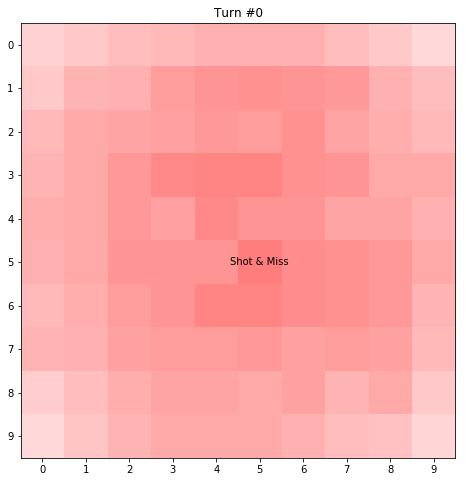

In [38]:
SModel_framer = single_frame_viz(0,game_hist=CNN_GameDict[2],  
                                 model_obj=None, 
                                 obs_3d=True,                         
                                 model_agent=True,
                                 board_shape=(10,10), 
                                 value_range=(-1,1),title='Turn #0')


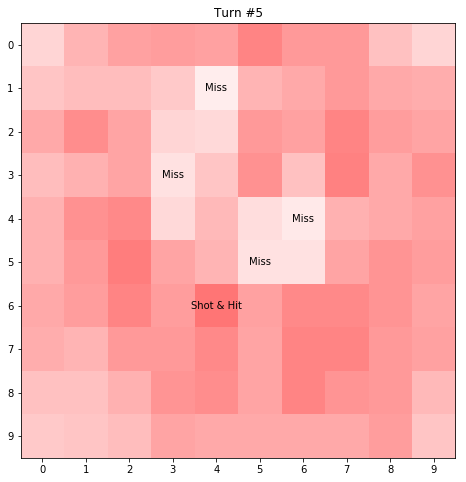

In [80]:
SModel_framer = single_frame_viz(4,game_hist=CNN_GameDict[2],  
                                 model_obj=None, 
                                 obs_3d=True,                         
                                 model_agent=True,
                                 board_shape=(10,10), 
                                 value_range=(-1,1),title='Turn #5')


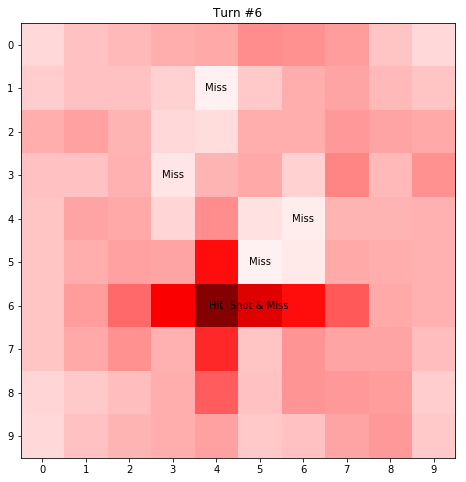

In [79]:
SModel_framer = single_frame_viz(5,game_hist=CNN_GameDict[2],  
                                 model_obj=None, 
                                 obs_3d=True,                         
                                 model_agent=True,
                                 board_shape=(10,10), 
                                 value_range=(-1,1),title='Turn #6')


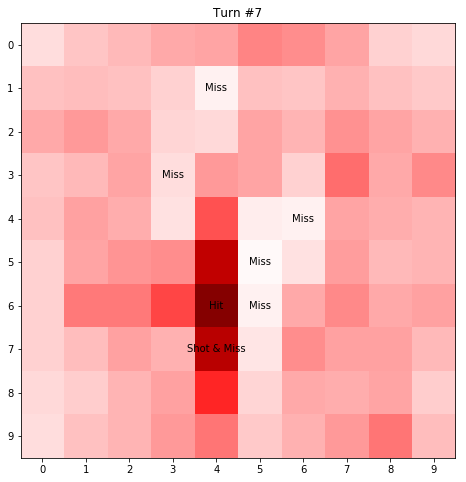

In [78]:
SModel_framer = single_frame_viz(6,game_hist=CNN_GameDict[2],  
                                 model_obj=None, 
                                 obs_3d=True,                         
                                 model_agent=True,
                                 board_shape=(10,10), 
                                 value_range=(-1,1),title='Turn #7')


In [ ]:
# CNN_Model_game = game_viz(board_shape=(10,10),
#                           agent_name='CNN_Model_Agent', 
#                           game_hist=CNN_GameDict[2],
#                           anim_flag=True, 
#                           model_agent=True,
#                           obs_3d=True,
#                           value_range=(-1,1))

![SegmentLocal](images\CNN_Model_Agent_Game.gif "segment")

## DQN Agent

This is the typical DQN agent, which formula the strategy based on Q table. I have tried 3 types of implementation. 

* __Keras RL__: this is the off the shelf model. However, it doesn't perform well. After over thousands steps of training, it failed to converge.
* __Single & Double Model DQN__: I then build customized agent. The main change I have done are:
    * __MASK ILLEGAL MOVEMENT__: one problem I notice from Keras RL is that the agent keep placing shots on the same cells again and again. To speed up the training, I have removed those explored cells from DQN's action space. Currently, my agent will only place these duplicated shots during exploration phase.
    * __MODEL PRE-TRAIN__: Instead of training the model from scratch, I first train the model with the game logs from the hunt  & target agent. For my models, I have used 1,000 games from the hunt and target agents. Result shows this step significantly improves my agent's performance. 

### Keras RL

In [13]:
dqn_env = gym.make('battleshipBasic-v0',board_shape=(10,10), verbose=False,obs_3d=True)
nb_actions = dqn_env.action_space.n
frame = Input(shape=(1, 10, 10,3))
x = Flatten()(frame)
x = Dense(32, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dense(32, activation='relu')(x)
output = Dense(nb_actions, activation='linear')(x)
model2 = Model(inputs=frame, outputs=output)
print(model2.summary())
# return model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1, 10, 10, 3)      0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 300)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                9632      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_6 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               3300      
Total params: 15,044
Trainable params: 15,044
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
policy = EpsGreedyQPolicy()
# policy = GreedyQPolicy()
memory = SequentialMemory(limit=50000, window_length=1)
dqn = DQNAgent(model=model2, nb_actions=nb_actions, memory=memory, 
               nb_steps_warmup=400,
               gamma=.99, target_model_update=1e-3, 
               policy=policy)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])
dqn.fit(dqn_env, nb_steps=50000, visualize=False, verbose=2)

Training for 50000 steps ...
   983/50000: episode: 1, duration: 5.035s, episode steps: 983, steps per second: 195, episode reward: -892999920.000, mean reward: -908443.459 [-1000000.000, 9.000], mean action: 56.641 [0.000, 99.000], mean observation: 0.328 [0.000, 1.000], loss: 428911453145.292114, mean_absolute_error: 22256.516996, mean_q: -537.728797
  3843/50000: episode: 2, duration: 16.801s, episode steps: 2860, steps per second: 170, episode reward: -2764999925.000, mean reward: -966783.191 [-1000000.000, 9.000], mean action: 54.203 [0.000, 99.000], mean observation: 0.475 [0.000, 1.000], loss: 67856904192.000000, mean_absolute_error: 1162925.375000, mean_q: -894480.625000
  5531/50000: episode: 3, duration: 10.209s, episode steps: 1688, steps per second: 165, episode reward: -1596999921.000, mean reward: -946090.001 [-1000000.000, 9.000], mean action: 52.824 [0.000, 98.000], mean observation: 0.383 [0.000, 1.000], loss: 45791084544.000000, mean_absolute_error: 2517975.750000, me

__Notes__: apparently, the agloirhtm failed to converge

### Single Model 

In [47]:
class Agent(object):
    def __init__(self, state_size, action_size, verbose=False, model=None, log_saving=False):
        self.verbose = verbose
        self.weight_backup = r".\model\DQN_V2_06082020_5.model"
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.model_estimates = None
        self.learning_rate = 0.0001
        self.gamma = 0.1
        self.exploration_rate = 0.4
        self.exploration_min = 0.01
        self.exploration_decay = 0.995
        self.log_saving = log_saving
        self.obs_hist = None
        self.shot_log = []
        self.model_estimates = None
        if model is None:
            self.brain = self._build_model(self.state_size)
        else:
            self.brain = model

    def model_pretrain(self, game_logs, batch_size, epochs):
        train_x, train_y = train_data_process(game_logs, reward=True)
        self.brain.fit(train_x, train_y,
                       batch_size=batch_size,
                       epochs=epochs, verbose=2)
        self.save_model()

    def _build_model(self, input_shape):
        X_input = Input(input_shape)
        X = ZeroPadding2D((3, 3))(X_input)
        X = Conv2D(32, (7, 7), strides=(1, 1), name='conv0')(X)
        X = BatchNormalization(axis=3, name='bn0')(X)
        X = ZeroPadding2D((3, 3))(X)
        X = Conv2D(32, (7, 7), strides=(1, 1), name='conv1')(X)
        X = BatchNormalization(axis=3, name='bn1')(X)
        X = Activation('relu')(X)
        X = MaxPooling2D((2, 2), name='max_pool')(X)
        # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
        X = Flatten()(X)
#         X = Dense(100, activation='sigmoid', name='fc')(X)
        X = Dense(100, activation='linear', name='fc')(X)
        # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
        model = Model(inputs=X_input, outputs=X, name='HappyModel')
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        if os.path.isfile(self.weight_backup):
            model.load_weights(self.weight_backup)
            self.exploration_rate = self.exploration_min
        print(model.summary())
        return model

    def save_model(self):
        self.brain.save(self.weight_backup)

    def act(self, state, explore=True):
        if explore and (np.random.rand() <= self.exploration_rate):
            return random.randrange(self.action_size), 1
        act_values = self.brain.predict(state)[0]
        if self.log_saving:
            if self.model_estimates is None:
                self.model_estimates = act_values.reshape((1,) + act_values.shape)
            else:
                self.model_estimates = np.concatenate([self.model_estimates, act_values.reshape((1,) + act_values.shape)])
        act_values[state[..., 0].flatten() != 0] = -99
        return np.argmax(act_values), 0

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self, sample_batch_size):
        if len(self.memory) < sample_batch_size:
            return
        sample_batch = random.sample(self.memory, sample_batch_size)
        state_input = np.array([])
        target_input = np.array([])
        for state, action, reward, next_state, done in sample_batch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.brain.predict(next_state)[0])
            target_f = self.brain.predict(state)
            target_f[0][state[...,0].flatten() !=0] = np.where(target_f[0][state[...,0].flatten() != 0] < -9,
                                                               target_f[0][state[...,0].flatten() != 0],
                                                               -9)
            target_f[0][action] = target
            if sum(state_input.shape) == 0:
                state_input = state
                target_input = target_f
            else:
                state_input = np.concatenate([state_input, state])
                target_input = np.concatenate([target_input, target_f])
        self.brain.fit(state_input, target_input, batch_size=32, epochs=2, verbose=1)
        if self.exploration_rate > self.exploration_min:
            self.exploration_rate *= self.exploration_decay


class BattleShipAgent:
    def __init__(self, agent=None, model=None, log_saving=False, verbose=False, episodes=10000):
        self.sample_batch_size = 500
        self.episodes = episodes
        self.env = gym.make('battleshipBasic-v0', board_shape=(10, 10),  verbose=False, obs_3d=True)
        self.state_size = self.env.observation_space.shape
        self.action_size = self.env.action_space.n
        self.verbose = verbose
        self.agent = agent
        self.obs_hist = None
        self.shot_log = []
        self.log_saving = log_saving
        self.model_estimates = None
        if self.agent is None:
            self.agent = Agent(state_size=self.state_size, action_size=self.action_size,
                               model=model, log_saving=log_saving)
            
    def reset_log(self):
        self.obs_hist = None
        self.shot_log = []
        self.model_estimates = None  
        self.agent.model_estimates = None      

    def train(self):
        try:
            total_step_log = []
            for index_episode in range(self.episodes):
                state = self.env.reset()
                state = np.reshape(state, (1,) + self.state_size)
                done = False
                total_reward = 0
                total_step = 0
                explore_step_count = 0
                while not done:
                    action, explore_count = self.agent.act(state)
                    explore_step_count += explore_count
                    next_state, reward, done, _ = self.env.step(action)
                    next_state = np.reshape(next_state, (1,)+ self.state_size)
                    self.agent.remember(state, action, reward, next_state, done)
                    state = next_state
                    total_reward += reward
                    total_step += 1
                    if self.verbose:
                        print(reward)
                total_step_log += [total_step]
                print("Episode {}# Score: {} and step {} ({} explore steps), "
                      "current average steps {}".format(index_episode,
                                                        total_reward, total_step,
                                                        explore_step_count,
                                                        np.mean(total_step_log)))
                self.agent.replay(self.sample_batch_size)
                if (index_episode%100) == 0:
                    self.agent.save_model()
        finally:
            self.agent.save_model()

    def test(self, env):
        obs, done, ep_reward = env.reset(), False, 0
        i = 0
        while not done:
            i += 1
            obs = np.reshape(obs, (1,) + self.state_size)
            action, _ = self.agent.act(obs, explore=False)
            obs, reward, done, _ = env.step(action)
            if self.log_saving:
                if i == 1:
                    self.obs_hist = obs.reshape((1,) + obs.shape)
                    self.shot_log = [action]
                else:
                    self.obs_hist = np.concatenate([self.obs_hist, obs.reshape((1,) + obs.shape)])
                    self.shot_log += [action]
            ep_reward += reward
        self.model_estimates = self.agent.model_estimates
        return i, ep_reward



In [107]:
# print('average steps uses is {}'.format(DQN_SingleModel_GameRecord['steps'].mean()))

In [9]:
trained_DQN_model = load_model(r'.\..\agents\model\DQN_V2_06102020_1.model')
dqn_env = gym.make('battleshipBasic-v0',board_shape=(10,10), verbose=False, obs_3d=True)
DQN_SingleMdel = BattleShipAgent(model=trained_DQN_model, log_saving=False)
DQN_SingleModel_GameRecord,_ =\
    agent_test(agent=DQN_SingleMdel, 
               env=env, 
               game_rounds=500, 
               agent_name='DQN_SModel', 
               model_agent=True, 
               log_save=False)

    
print('average steps uses is {}'.format(DQN_SingleModel_GameRecord['steps'].mean()))
DQN_SingleModel_GameRecord.to_csv(r'c:\temp\DQN_SingleModel.csv')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:47<00:00, 10.49it/s]

average steps uses is 71.276


In [10]:
# trained_DQN_model = load_model(r'.\..\agents\model\DQN_V2_06102020_1.model')
# dqn_env = gym.make('battleshipBasic-v0',board_shape=(10,10), verbose=False, obs_3d=True)
# DQN_SingleMdel = BattleShipAgent(model=trained_DQN_model, log_saving=True)
# _,DQN_SingleMdel_GameDict =\
#     agent_test(agent=DQN_SingleMdel, 
#                env=env, 
#                game_rounds=10, 
#                agent_name='DQN_SModel', 
#                model_agent=True, 
#                log_save=True)

    
# # print('average steps uses is {}'.format(DQN_DoubleModel_GameRecord['steps'].mean()))

In [97]:
# DQN_SModel_game = game_viz(board_shape=(10,10),agent_name='DQN_SingleModel_Agent', 
#                            game_hist=DQN_SingleMdel_GameDict[2],
#                            anim_flag=True, 
#                            model_agent=True,
#                            obs_3d=True,
#                            value_range=(-20,+20))

![SegmentLocal](images\DQN_SingleModel_Agent_Game.gif "segment")

In [95]:
# # DQN_V2_06102020_1 DQN_V2_06082020_5
# # DQN_V2_06102020_2
# trained_DQN_model = load_model(r'.\..\agents\model\DQN_V2_06102020_1.model')
# dqn_env = gym.make('battleshipBasic-v0',board_shape=(10,10), verbose=False, obs_3d=True)
# DQN_SingleMdel = BattleShipAgent(model=trained_DQN_model, log_saving=False)
# # SearchHuntAgent1 = SearchHuntAgent(board_shape=(10,10), verbose=False, log_saving=True)
# step_record = []
# reward_record = []
# data_SModel_DQN_Agent ={}
# # for i in tqdm(range(1_000_000)):
# for i in tqdm(range(10), position=0, leave=True): 
#     DQN_SingleMdel.reset_log()
#     total_step, reward = DQN_SingleMdel.test(dqn_env)
#     step_record += [total_step]
#     reward_record += [reward]
#     if i <=10:
#         data_SModel_DQN_Agent[i] ={'observations': DQN_SingleMdel.obs_hist, 
#                           'target': dqn_env.board.map.flatten(), 
#                           'shot':DQN_SingleMdel.shot_log,
#                           'model_estimates':DQN_SingleMdel.model_estimates}
#     if i == 11:
#         DQN_SingleMdel.log_saving = False
# #     print(data_dict)

# # DQN_SingleModel_GameRecord = pd.DataFrame({'AgentName':['SearchHuntAgent']*len(step_record),
# #                                            'steps':step_record,
# #                                            'reward':reward_record})

In [96]:
# print('average steps uses is {}'.format(DQN_SingleModel_GameRecord['steps'].mean()))

In [94]:
# SModel_framer = single_frame_viz(7,game_hist=data_SModel_DQN_Agent[2],  
#                                  model_obj=None, 
#                                  obs_3d=True,                         
#                                  model_agent=True,
#                                  board_shape=(10,10), 
#                                  value_range=(-20,20))


### Double Model

In [11]:
class DQN:
    def __init__(self, env, model=None, log_saving=False):
        self.log_saving = log_saving
        self.env = env
        self.memory = deque(maxlen=2000)
        self.gamma = 0.9
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.7
        self.learning_rate = 0.0001
        self.exploration_min = 0.01
        self.exploration_rate = 0.4
        self.tau = .125
        self.obs_hist = None
        self.shot_log = []
        self.model_estimates = None
        self.state_shape = self.env.observation_space.shape
        # self.weight_backup = r'.\model\DQN_V3_06082020_3.model'
        self.weight_backup = r'.\model\DQN_V3_06092020_1.model'
        if model is not None:
            self.model = model
            self.target_model = model
        else:
            self.model = self.create_model(self.env.observation_space.shape)
            self.target_model = self.create_model(self.env.observation_space.shape)
            
    def reset_log(self):
        self.obs_hist = None
        self.shot_log = []
        self.model_estimates = None

    def create_model(self, input_shape):
        X_input = Input(input_shape)
        X = ZeroPadding2D((3, 3))(X_input)
        X = Conv2D(32, (7, 7), strides=(1, 1), name='conv0')(X)
        X = BatchNormalization(axis=3, name='bn0')(X)
        X = ZeroPadding2D((3, 3))(X)
        X = Conv2D(32, (7, 7), strides=(1, 1), name='conv1')(X)
        X = BatchNormalization(axis=3, name='bn1')(X)
        X = Activation('relu')(X)
        X = MaxPooling2D((2, 2), name='max_pool')(X)
        # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
        X = Flatten()(X)
#         X = Dense(100, activation='sigmoid', name='fc')(X)
        
        X = Dense(100, activation='linear', name='fc')(X)
        # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
        model = Model(inputs=X_input, outputs=X, name='HappyModel')
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        if os.path.isfile(self.weight_backup):
            model.load_weights(self.weight_backup)
            self.exploration_rate = self.exploration_min
        print(model.summary())
        return model

    def model_pretrain(self, game_logs, batch_size, epochs):
        train_x, train_y = train_data_process(game_logs, reward=True)
        self.target_model.fit(train_x, train_y,
                              batch_size=batch_size,
                              epochs=epochs, verbose=2)
        self.save_model(self.weight_backup)
        self.model.load_weights(self.weight_backup) # assign same weights

    def act(self, state, explore=True):
        self.epsilon *= self.epsilon_decay
        self.epsilon = max(self.epsilon_min, self.epsilon)
        if explore and (np.random.random() < self.epsilon):
            print('explore')
            return self.env.action_space.sample()
        act_values = self.model.predict(state)[0]
        if self.log_saving:
            if self.model_estimates is None:
                self.model_estimates = act_values.reshape((1,) + act_values.shape)
            else:
                self.model_estimates = np.concatenate([self.model_estimates, act_values.reshape((1,) + act_values.shape)])
        act_values[state[..., 0].flatten() != 0] = -99
        return np.argmax(act_values)

    def remember(self, state, action, reward, new_state, done):
        self.memory.append([state, action, reward, new_state, done])

    def replay(self):
        batch_size = 256
        if len(self.memory) < batch_size:
            return
        samples = random.sample(self.memory, batch_size)
        state_input = np.array([])
        target_input = np.array([])
        for sample in samples:
            state, action, reward, new_state, done = sample
            target = self.target_model.predict(state)
            if done:
                target[0][action] = reward
            else:
                Q_future = max(self.target_model.predict(new_state)[0])
                target[0][action] = reward + Q_future * self.gamma
            if sum(state_input.shape) == 0:
                state_input = state
                target_input = target
            else:
                state_input = np.concatenate([state_input, state])
                target_input = np.concatenate([target_input, target])
        self.model.fit(state_input, target_input, batch_size=32, epochs=2, verbose=1)

    def target_train(self):
        weights = self.model.get_weights()
        target_weights = self.target_model.get_weights()
        for i in range(len(target_weights)):
            target_weights[i] = weights[i] * self.tau + target_weights[i] * (1 - self.tau)
        self.target_model.set_weights(target_weights)

    def save_model(self, fn):
        self.target_model.save(fn)

    def test(self, env):
        obs, done, ep_reward = env.reset(), False, 0
        i = 0
        while not done:
            i += 1
            obs = np.reshape(obs, (1,) + obs.shape)
            action = self.act(obs, explore=False)
            obs, reward, done, _ = env.step(action)
            if self.log_saving:
                if i == 1:
                    self.obs_hist = np.reshape(obs, (1,) + obs.shape)
                    self.shot_log = [action]
                else:
                    self.obs_hist = np.concatenate([self.obs_hist, np.reshape(obs, (1,) + obs.shape)])
                    self.shot_log += [action]
            ep_reward += reward
        return i, ep_reward

    def train(self, env, trials=1000, game_logs=None):
        if game_logs is not None:
            self.model_pretrain(game_logs, 128, 4)
        steps = []
        for trial in range(trials):
            cur_state = env.reset()
            cur_state = np.reshape(cur_state, (1,) + env.observation_space.shape)
            total_reward = 0
            total_step = 0
            done = False
            while not done:
                action = self.act(cur_state)
                # print(action)
                new_state, reward, done, _ = env.step(action)
                new_state = np.reshape(new_state, (1,) + env.observation_space.shape)
                self.remember(cur_state, action, reward, new_state, done)
                cur_state = new_state
                total_reward += reward
                total_step += 1
            self.replay()  # internally iterates default (prediction) model
            if trial % 100 == 0:
                self.target_train()
                self.save_model(self.weight_backup)
            steps += [total_step]
            if len(steps) <= 200:
                mean_steps = np.mean(steps)
            else:
                mean_steps = np.mean(steps[-200:])
            print("Completed in {} trials with reward {} and step {}, average steps {}".format(trial,
                                                                                               total_reward, total_step,
                                                                                               mean_steps))
        self.save_model(self.weight_backup)

In [12]:
dqn_env = gym.make('battleshipBasic-v0',board_shape=(10,10), verbose=False, obs_3d=True)
# DQN_V3_06092020_2
trained_DQN_model = load_model(r'.\..\agents\model\DQN_V3_06102020_1.model')
dqn_DModel_agent_V1 = DQN(env=dqn_env, model=trained_DQN_model, log_saving=False)
DQN_DoubleModel_GameRecord,_ =\
    agent_test(agent=dqn_DModel_agent_V1, 
               env=env, 
               game_rounds=500, 
               agent_name='RandomAgent', 
               model_agent=True, 
               log_save=False)

    
print('average steps uses is {}'.format(DQN_DoubleModel_GameRecord['steps'].mean()))
DQN_DoubleModel_GameRecord.to_csv(r'c:\temp\DQN_Double.csv')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:41<00:00, 11.95it/s]

average steps uses is 60.19


In [63]:
dqn_env = gym.make('battleshipBasic-v0',board_shape=(10,10), verbose=False, obs_3d=True)
# DQN_V3_06092020_2
trained_DQN_model = load_model(r'.\..\agents\model\DQN_V3_06102020_1.model')
dqn_DModel_agent_V1 = DQN(env=dqn_env, model=trained_DQN_model, log_saving=True)
_,DQN_DoubleModel_GameDict =\
    agent_test(agent=dqn_DModel_agent_V1, 
               env=env, 
               game_rounds=10, 
               agent_name='RandomAgent', 
               model_agent=True, 
               log_save=True)

    
# print('average steps uses is {}'.format(DQN_DoubleModel_GameRecord['steps'].mean()))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.01it/s]


In [65]:
1/9.01

0.11098779134295228

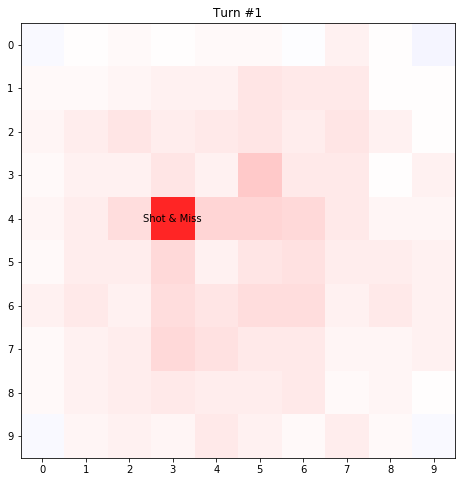

In [65]:
SModel_framer = single_frame_viz(0,game_hist=DQN_DoubleModel_GameDict[2],  
                                 model_obj=None, 
                                 obs_3d=True,                         
                                 model_agent=True,
                                 board_shape=(10,10), 
                                 value_range=(-20,20),
                                title='Turn #1')


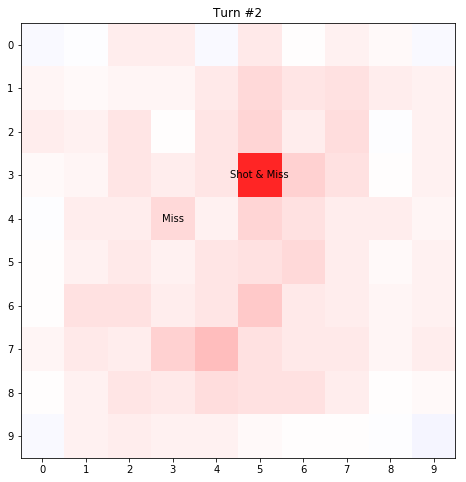

In [66]:
SModel_framer = single_frame_viz(1,game_hist=DQN_DoubleModel_GameDict[2],  
                                 model_obj=None, 
                                 obs_3d=True,                         
                                 model_agent=True,
                                 board_shape=(10,10), 
                                 value_range=(-20,20),
                                title='Turn #2')


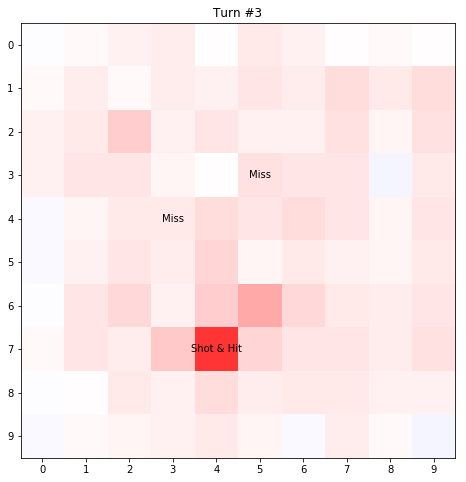

In [71]:
SModel_framer = single_frame_viz(2,game_hist=DQN_DoubleModel_GameDict[2],  
                                 model_obj=None, 
                                 obs_3d=True,                         
                                 model_agent=True,
                                 board_shape=(10,10), 
                                 value_range=(-20,20),
                                title='Turn #3')


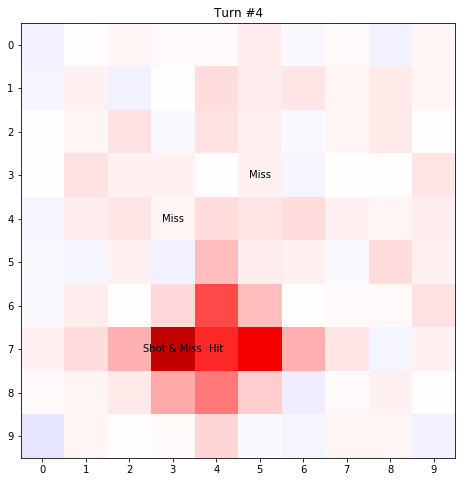

In [72]:
SModel_framer = single_frame_viz(3,game_hist=DQN_DoubleModel_GameDict[2],  
                                 model_obj=None, 
                                 obs_3d=True,                         
                                 model_agent=True,
                                 board_shape=(10,10), 
                                 value_range=(-20,20),
                                title='Turn #4')


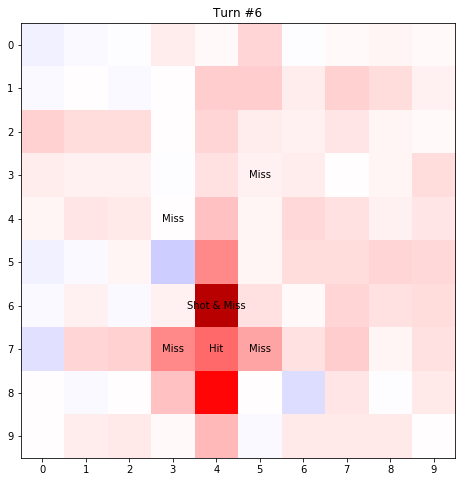

In [77]:
SModel_framer = single_frame_viz(5,game_hist=DQN_DoubleModel_GameDict[2],  
                                 model_obj=None, 
                                 obs_3d=True,                         
                                 model_agent=True,
                                 board_shape=(10,10), 
                                 value_range=(-20,20),
                                title='Turn #6')


In [92]:
# DQN_DModel_game = game_viz(board_shape=(10,10),agent_name='DQN_DoubleModel_Agent', 
#                            game_hist=DQN_DoubleModel_GameDict[1],
#                            anim_flag=True, 
#                            model_agent=True,
#                            obs_3d=True ,
#                           value_range=(-20,+20))

![SegmentLocal](images\DQN_DoubleModel_Agent_Game.gif "segment")

In [100]:
# HTML(DQN_DModel_game.to_html5_video())

In [35]:
# dqn_env = gym.make('battleshipBasic-v0',board_shape=(10,10), verbose=False, obs_3d=True)
# # DQN_V3_06092020_2
# trained_DQN_model = load_model(r'.\..\agents\model\DQN_V3_06102020_1.model')
# dqn_agent_V3 = DQN(env=dqn_env, model=trained_DQN_model, log_saving=True)

# step_record = []
# reward_record = []
# data_dict_agent3 ={}
# # for i in tqdm(range(1_000_000)):
# for i in tqdm(range(1_000), position=0, leave=False): 
#     dqn_agent_V3.reset_log()
#     total_step, reward = dqn_agent_V3.test(dqn_env)
#     step_record += [total_step]
#     reward_record += [reward]
#     if i <= 10:
#         data_dict_agent3[i] ={'observations': dqn_agent_V3.obs_hist,
#                           'target': dqn_env.board.map.flatten(), 
#                           'shot':dqn_agent_V3.shot_log,
#                          'model_estimates':dqn_agent_V3.model_estimates}
# #     print(data_dict)

# DQN_DoubleModel_GameRecord = pd.DataFrame({'AgentName':['SearchHuntAgent']*len(step_record),
#                                            'steps':step_record,
#                                            'reward':reward_record})

In [36]:
# print('average steps uses is {}'.format(DQN_DoubleModel_GameRecord['steps'].mean()))

## MC Agent

In [27]:
class MCAgent(object):
    def __init__(self, board_shape, multiprocess=True, verbose=False, log_saving=False, simulation_round=100):
        self.verbose = verbose
        self.shape = board_shape
        self.log_saving = log_saving
        self.obs_hist = None
        self.pool = Pool()
        self.simulation_round = simulation_round
        self.multiprocess = multiprocess
        self.hunt_queue = []
        self.shot_log = []
        self.prev_obs = np.zeros([self.shape[0], self.shape[1]], dtype=np.int16)
        self.model_estimates = None
        # self.pool = Pool()  # Create a multiprocessing Pool

    def __getstate__(self):
        self_dict = self.__dict__.copy()
        del self_dict['pool']
        return self_dict

    @staticmethod
    def check_place(ship_loc, miss_map, curr_ship_map):
        if ship_loc[0][0] == ship_loc[1][0]:  # this is a horizontal ship
            miss_map_vals = miss_map[ship_loc[0][0], ship_loc[0][1]:ship_loc[1][1]]
            curr_ship_map_vals = curr_ship_map[ship_loc[0][0], ship_loc[0][1]:ship_loc[1][1]]
        elif ship_loc[0][1] == ship_loc[1][1]:
            miss_map_vals = miss_map[ship_loc[0][0]:ship_loc[1][0], ship_loc[0][1]]
            curr_ship_map_vals = curr_ship_map[ship_loc[0][0]:ship_loc[1][0], ship_loc[0][1]]
        else:
            return False
        miss_unique = np.unique(miss_map_vals)
        curr_unique = np.unique(curr_ship_map_vals)
        if (miss_unique[0] == 0) & (curr_unique[0] == 0) & (len(miss_unique) == 1) & (len(curr_unique) == 1):
            return True
        else:
            return False

    @staticmethod
    def assign_ship(target_baord, loc):
        if loc[0][0] == loc[1][0]:
            target_baord[loc[0][0], loc[0][1]:loc[1][1]] = 1
        else:
            target_baord[loc[0][0]:loc[1][0], loc[0][1]] = 1
        return target_baord

    @staticmethod
    def check_board(board, obs):
        sunk_ids = board.sunk
        simu_starting_board = np.zeros(board.shape, dtype=np.int16)
        curr_missing_board = np.zeros(board.shape, dtype=np.int16)
        occupied_cell = []
        missed_shot = np.where(obs == 1)
        missed_shot_loc = []
        for i in range(np.shape(missed_shot)[1]):
            missed_shot_loc += [missed_shot[1][i] + missed_shot[0][i] * 10]
        curr_missing_board[missed_shot] = 1
        hit_shot = np.where(obs == 2)
        hit_shot_loc = []
        for i in range(np.shape(hit_shot)[1]):
            hit_shot_loc += [hit_shot[1][i] + hit_shot[0][i] * 10]
        for sunk_id in sunk_ids:
            _sunk_locs = board.ships[sunk_id].loc
            if _sunk_locs[0][0] == _sunk_locs[1][0]:
                simu_starting_board[_sunk_locs[0][0], _sunk_locs[0][1]:_sunk_locs[1][1]] = 1
                curr_ship_cell = [_sunk_locs[0][0] * board.shape[0] + i for i in range(_sunk_locs[0][1], _sunk_locs[1][1])]
                assert len(curr_ship_cell) == board.ships[sunk_id].length
                occupied_cell += curr_ship_cell
            else:
                simu_starting_board[_sunk_locs[0][0]:_sunk_locs[1][0], _sunk_locs[0][1]] = 1
                curr_ship_cell = [i * board.shape[0] + _sunk_locs[0][1] for i in range(_sunk_locs[0][0], _sunk_locs[1][0])]
                assert len(curr_ship_cell) == board.ships[sunk_id].length
                occupied_cell += curr_ship_cell
        available_hit_cell = list(set(hit_shot_loc) - set(occupied_cell))
        empty_cell = list(set(np.arange(board.shape[0]*board.shape[1])) - set(occupied_cell) -
                          set(missed_shot_loc) - set(available_hit_cell))
        return simu_starting_board, curr_missing_board, empty_cell, available_hit_cell

    def convert_loc(self, loc, board_shape):
        y, x = divmod(loc, board_shape[0])
        return y, x

    def multiprocessing_simulation(self,  board, obs, simulation_num=1000):
        start_time = time.time()
        available_ship_ids = [_id for _id in board.ships.keys() if _id not in board.sunk]
        get_ship_time = time.time()
        if self.verbose:
            print('time used for get ship id, ', (get_ship_time - start_time))
        starting_board, missing_board, all_loc_sapce, hit_loc_space = \
            self.check_board(board, obs)
        check_board_time = time.time()
        if self.verbose:
            print('time used for check_board, ', (check_board_time - get_ship_time))
        ship_len_dict = {_id: board.ships[_id].length for _id in board.ships.keys()}
        partial_func = functools.partial(self.signle_simulation,
                                         board,
                                         available_ship_ids,
                                         starting_board,
                                         missing_board,
                                         all_loc_sapce,
                                         hit_loc_space,
                                         ship_len_dict)
        partial_func_time = time.time()
        if self.verbose:
            print('time used for partial function, ', (partial_func_time - check_board_time))
        pool_creation = time.time()
        if self.verbose:
            print('time used for pool function, ', (pool_creation - partial_func_time))
        if simulation_num == 1:
            all_output = partial_func(1)
            return all_output
        elif self.multiprocess:
            all_output = self.pool.map(partial_func, range(simulation_num))  # process data_inputs iterable with pool
        else:
            all_output = np.zeros((simulation_num,)+board.shape)
            for i in range(simulation_num):
                all_output[i] = partial_func(1)
        simulation_time = time.time()
        if self.verbose:
            print('time used for simulation function, ', (simulation_time - pool_creation))
        return np.sum(all_output, axis=0)

    def signle_simulation(self, board, available_ship_ids, starting_board,
                          missing_board, all_loc_sapce, hit_loc_space,ship_len_dict,count):
        map_finish = False
        board_shape = starting_board.shape
        tot_assign = 0
        illgeal_pos = missing_board + starting_board
        while not map_finish:
            curr_ship_ids = copy.copy(available_ship_ids)
            curr_simulation_board = copy.copy(starting_board)
            curr_all_loc_sapce = copy.copy(all_loc_sapce)
            curr_hit_loc_space = copy.copy(hit_loc_space)
            np.random.shuffle(curr_ship_ids)
            np.random.shuffle(curr_all_loc_sapce)
            assign_ships = []
            if len(hit_loc_space) > 0:
                np.random.shuffle(curr_hit_loc_space)
            for j in range(len(curr_ship_ids)):
                curr_ship_len = ship_len_dict[curr_ship_ids[j]]
                assigned = False
                # while not assigned
                if len(curr_hit_loc_space) > 0:
                    for k in range(len(curr_hit_loc_space)):
                        direction = np.random.randint(2)
                        if direction == 0: # horizontal
                            choice_list = [curr_hit_loc_space[k] - shift for shift in range(curr_ship_len)
                                           if ((curr_hit_loc_space[k] - shift) >= 0) &
                                           (curr_hit_loc_space[k] % 10 - shift + curr_ship_len <= 10)]
                            if len(choice_list) == 0:
                                break
                            loc = np.random.choice(choice_list, 1)[0]
                            ship_loc = [self.convert_loc(loc,board_shape),
                                        (self.convert_loc(loc,board_shape)[0],
                                         self.convert_loc(loc,board_shape)[1] + curr_ship_len)]
                        else:# vertical
                            choice_list = [curr_hit_loc_space[k] - shift * board_shape[0]
                                           for shift in range(curr_ship_len)
                                           if ((curr_hit_loc_space[k] - shift * board_shape[0]) >= 0) &
                                           ((curr_hit_loc_space[k] // 10 + (curr_ship_len - shift)) <= 10) &
                                           ((curr_hit_loc_space[k] // 10 + (curr_ship_len - shift)) >= 0)]
                            if len(choice_list) == 0:
                                break
                            loc = np.random.choice(choice_list, 1)[0]
                            ship_loc = [self.convert_loc(loc, board_shape),
                                        (self.convert_loc(loc,board_shape)[0] + curr_ship_len,
                                         self.convert_loc(loc, board_shape)[1])]
                        if self.check_place(ship_loc, missing_board, curr_simulation_board):
                            curr_simulation_board = self.assign_ship(curr_simulation_board, ship_loc)
                            ship_cells = [(ship_loc[0][0], ship_loc[0][1] + i) if direction == 0
                                          else (ship_loc[0][0] + i, ship_loc[0][1]) for i in range(curr_ship_len)]
                            for cell in ship_cells:
                                cell_num = cell[0] * board_shape[0] + cell[1]
                                if cell_num in curr_hit_loc_space:
                                    curr_hit_loc_space.remove(cell_num)
                            assign_ships += [curr_ship_ids[j]]
                            tot_assign += 1
                            # if self.verbose:
                            #     print('currently working on ship', curr_ship_ids[j], 'with assignment',
                            #           ship_loc, 'assigned ships are ', assign_ships)
                            assigned = True
                            break
                if not assigned:
                    for k in range(len(curr_all_loc_sapce)):
                        hrz_list =[_loc for _loc in curr_all_loc_sapce if(_loc % 10 + curr_ship_len <= 10) &
                                   (np.sum(illgeal_pos[self.convert_loc(_loc,board_shape)[0],
                                           self.convert_loc(_loc, board_shape)[1]:
                                           self.convert_loc(_loc, board_shape)[1] + curr_ship_len]) == 0)]
                        vert_list = [_loc for _loc in curr_all_loc_sapce if ((_loc // 10 + curr_ship_len) <= 10) &
                                     (np.sum(illgeal_pos[self.convert_loc(_loc, board_shape)[0]:
                                                         self.convert_loc(_loc,board_shape)[0] + curr_ship_len,
                                             self.convert_loc(_loc, board_shape)[1]]) == 0)]
                        if len(hrz_list) == len(vert_list) == 0:
                            break
                        elif len(hrz_list) == 0:
                            direction = 1
                        elif len(vert_list) == 0:
                            direction = 0
                        else:
                            direction = np.random.randint(2)

                        if direction == 0:
                            loc = np.random.choice(hrz_list, 1)[0]
                            ship_loc = [self.convert_loc(loc,board_shape),
                                        (self.convert_loc(loc,board_shape)[0],
                                         self.convert_loc(loc,board_shape)[1] + curr_ship_len)]
                        else:
                            loc = np.random.choice(vert_list, 1)[0]
                            ship_loc = [self.convert_loc(loc, board_shape),
                                        (self.convert_loc(loc,board_shape)[0] + curr_ship_len,
                                         self.convert_loc(loc, board_shape)[1])]
                        if self.check_place(ship_loc, missing_board, curr_simulation_board):
                            curr_simulation_board = self.assign_ship(curr_simulation_board, ship_loc)
                            curr_all_loc_sapce.remove(loc)
                            assign_ships += [curr_ship_ids[j]]
                            # if self.verbose:
                            #     print('currently working on ship', curr_ship_ids[j], 'with assignment',
                            #           ship_loc, 'assigned ships are ', assign_ships)
                            assigned = True
                            tot_assign += 1
                            break
                    if not assigned:
                        break  # ship assignment failed start-over again.
            if len(assign_ships) != len(curr_ship_ids):
                continue
            else:
                return curr_simulation_board

    def reset_log(self):
        self.shot_log = []
        self.obs_hist = None
        self.model_estimates = None

    def action(self, obs, board):
        if len(obs.shape) == 3:
            obs = obs[..., 0] + obs[..., 2]  # flatten the inputs
        mc_estimation_est_orig = self.multiprocessing_simulation(board, obs, self.simulation_round)
        mc_estimation_est = (mc_estimation_est_orig/ self.simulation_round).flatten()
        if self.log_saving:
            if self.model_estimates is None:
                self.model_estimates = mc_estimation_est.reshape((1,) + mc_estimation_est.shape)
            else:
                self.model_estimates = np.concatenate([self.model_estimates, mc_estimation_est.reshape((1,) + mc_estimation_est.shape)])
        flatten_obs = obs.flatten()
        mc_estimation_est[flatten_obs > 0] = -1  # assign shoot position as -1
        action_val = np.argmax(mc_estimation_est)
        if self.verbose:
            print(mc_estimation_est_orig)
            print(obs)
            print(mc_estimation_est)
            print(action_val)
        return action_val

    def test(self, env):
        obs, done, ep_reward = env.reset(), False, 0
        i = 0
        while not done:
            i += 1
            if self.verbose:
                print('###### Round ', i, '############')
                print(time.time())
            action = self.action(obs, env.board)
            if len(obs.shape) == 3:
                obs = obs[..., 0] + obs[..., 2]  # flatten the inputs
            self.prev_obs = obs
            obs, reward, done, _ = env.step(action)
            if self.log_saving:
                if i == 1:
                    self.obs_hist = obs.reshape((1,) + obs.shape)
                    self.shot_log = [action]
                else:
                    self.obs_hist = np.concatenate([self.obs_hist, obs.reshape((1,) + obs.shape)])
                    self.shot_log += [action]
            ep_reward += reward
        return i, ep_reward


Without Multiprocessing, the MC_Agent takes ~1 mins to finish a game. With multiprocessing, each game only takes ~10 seconds. However, this is still much slower compared with other agents.

In [28]:

env_mc = gym.make('battleshipBasic-v0',board_shape=(10,10), verbose=False, obs_3d=False)
MC_Agent1 = MCAgent(board_shape=(10,10),multiprocess=False,  verbose=False, log_saving=True, simulation_round=500)
MCAgent_GameRecord,MCAgent_GameDict =\
    agent_test(agent=MC_Agent1, 
               env=env_mc,                
               game_rounds=2, 
               agent_name='MCAgent', 
               model_agent=True, 
               log_save=True)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:26<00:00, 73.40s/it]


In [29]:
MCAgent_GameDict[0]['observations'][0].shape

(10, 10)

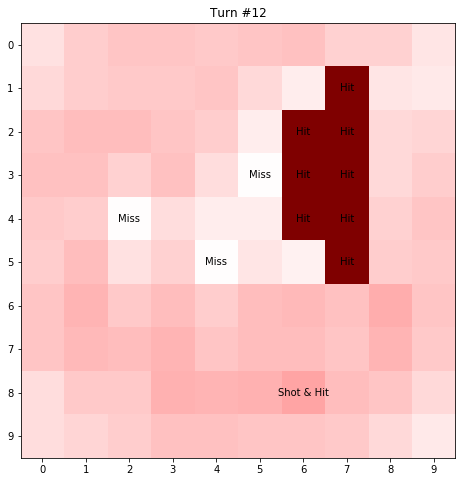

In [43]:
# SModel_framer = single_frame_viz(11,game_hist=MCAgent_GameDict[0],  
#                                  model_obj=None, 
#                                  obs_3d=False,                         
#                                  model_agent=True,
#                                  board_shape=(10,10), 
#                                  value_range=(-1,1),
#                                 title='Turn #12',
#                                 label_c='Black')


## Result Summary

Following plot shows the result comparison among my agents.

* The CNN model based agent performs the best with average steps around 55.
* The double models DQN performs slightly worse compared with CNN with an average steps of 58.
* The single model DQN didn't beat the hunt & target agent with an average steps of 72

In [60]:
MC_GameRecord = pd.read_csv(r'c:\temp\MC_Agent_test.csv')
RandomAgent_GameRecord = pd.read_csv(r'c:\temp\RandomAgentResult.csv')
HuntTargetAgent_GameRecord= pd.read_csv(r'c:\temp\HuntTargetAgentResult.csv')
DQN_SingleModel_GameRecord= pd.read_csv(r'c:\temp\DQN_SingleModel.csv')
DQN_DoubleModel_GameRecord= pd.read_csv(r'c:\temp\DQN_Double.csv')
CNN_GameRecord= pd.read_csv(r'c:\temp\CNN_gameRecord.csv')

In [74]:
print(RandomAgent_GameRecord.median())
print(MC_GameRecord.max())
print(HuntTargetAgent_GameRecord.mean())
print(DQN_SingleModel_GameRecord.mean())
print(DQN_DoubleModel_GameRecord.mean())
print(CNN_GameRecord.mean())
# print(RandomAgent_GameRecord.mean())

Unnamed: 0    249.5
steps          97.0
reward         73.0
dtype: float64
Unnamed: 0           499
AgentName     battleship
steps                 70
reward               148
dtype: object
Unnamed: 0    249.500
steps          66.228
reward        103.772
dtype: float64
Unnamed: 0    249.500
steps          71.276
reward         98.724
dtype: float64
Unnamed: 0    249.50
steps          60.19
reward        109.81
dtype: float64
Unnamed: 0    249.500
steps          55.344
reward        114.656
dtype: float64


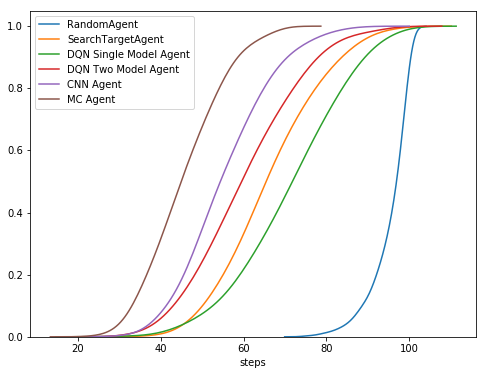

In [70]:
# all_record['steps'].hist(cumulative=True,
# #                          density=1, 
#                          bins=1000,figsize=(12,4))
# plt.show()
import seaborn as sns
fig, ax = plt.subplots(figsize=(8,6))
kwargs = {'cumulative': True}
sns.distplot(RandomAgent_GameRecord['steps'],  kde_kws=kwargs,
             ax=ax, kde=True,hist=False, label='RandomAgent')
sns.distplot(HuntTargetAgent_GameRecord['steps'],ax=ax, kde_kws=kwargs,
             kde=True,hist=False, label='SearchTargetAgent')
sns.distplot(DQN_SingleModel_GameRecord['steps'],ax=ax, kde_kws=kwargs,
             kde=True,hist=False, label='DQN Single Model Agent')
sns.distplot(DQN_DoubleModel_GameRecord['steps'],ax=ax, kde_kws=kwargs,
             kde=True,hist=False, label='DQN Two Model Agent')
sns.distplot(CNN_GameRecord['steps'],ax=ax, kde_kws=kwargs,
             kde=True,hist=False, label='CNN Agent')
sns.distplot(MC_GameRecord['steps'],ax=ax, kde_kws=kwargs,
             kde=True,hist=False, label='MC Agent')
# ax.set_xlim([0, 100])